In [2]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
#plt.gray()
galaxy_name = 'DDO126'

# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 126\d126u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 126\d126b.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data\DDO 126\d126v.fits")
light_v = light_file_v[0].data

box_u = (120 , 120)
box_b = (180 , 180)
box_v = (150 , 150)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]
print(np.shape(light_u), np.shape(light_b),np.shape(light_v))

(961, 902) (961, 902) (961, 902)


(961, 902) ((961, 902), (961, 902))


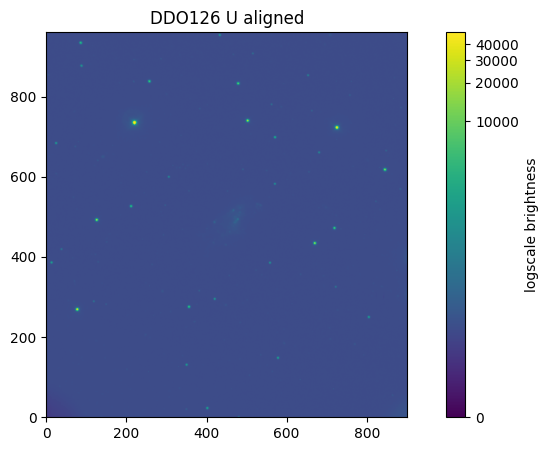

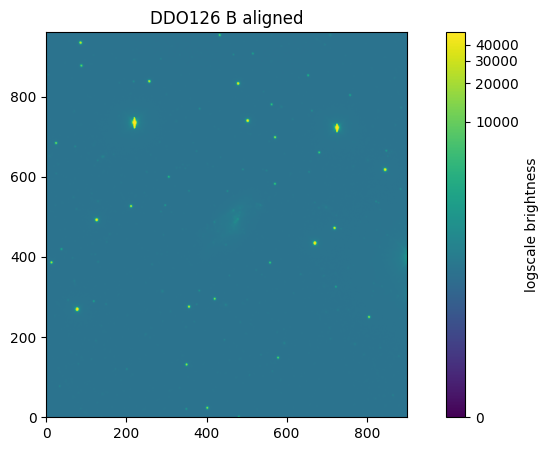

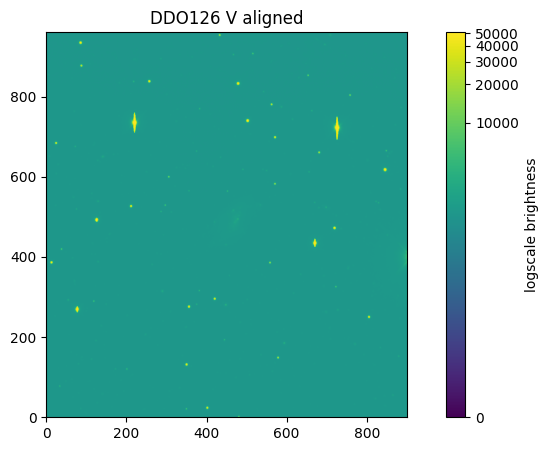

In [5]:
import astroalign as aa
target_fixed = lights[0].byteswap().newbyteorder('N')
source_fixed_1 = lights[1].byteswap().newbyteorder('N')
source_fixed_2 = lights[2].byteswap().newbyteorder('N')
registered_image_1, footprint_1 = aa.register(source_fixed_1, target_fixed)
registered_image_2,  footprint_2 = aa.register(source_fixed_2, target_fixed)
list_of_aligned_images = [lights[0],registered_image_1, registered_image_2 ]
print(np.shape(list_of_aligned_images[0]),(np.shape(list_of_aligned_images[1]),np.shape(list_of_aligned_images[2])))
aligned = list_of_aligned_images
for i in range(0,3):
    ltf.log_scale_plot(aligned[i],"%s %s aligned"%(galaxy_name,filters[i]),"logscale brightness")

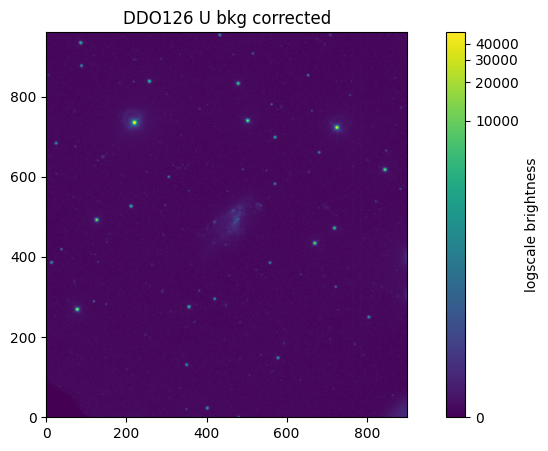

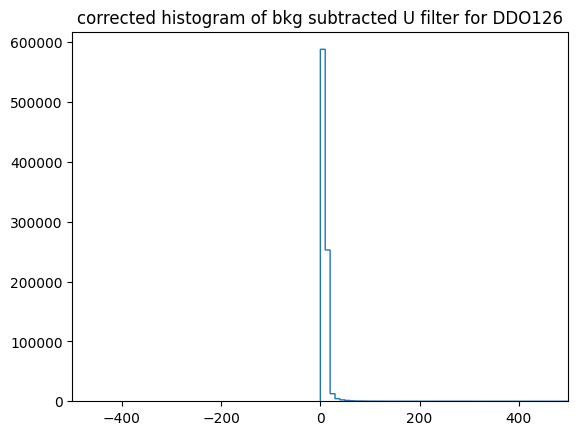

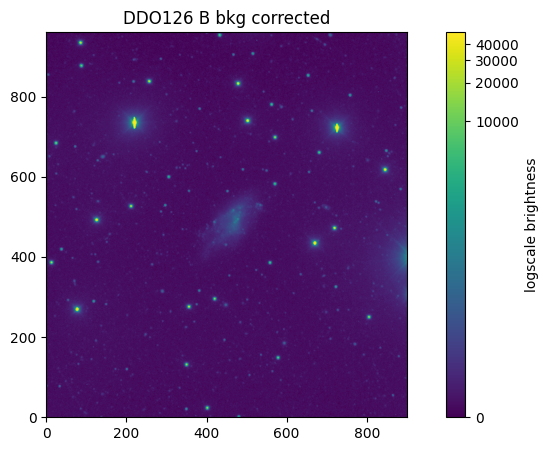

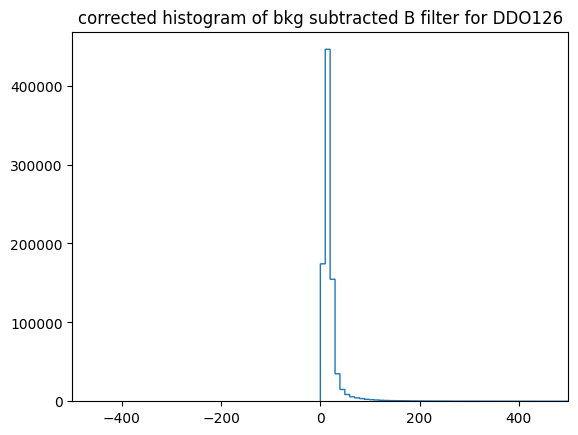

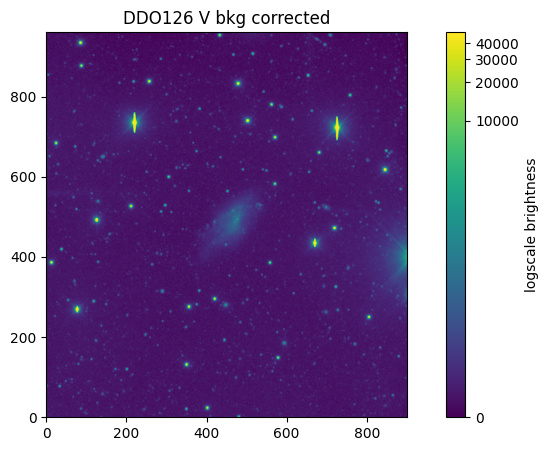

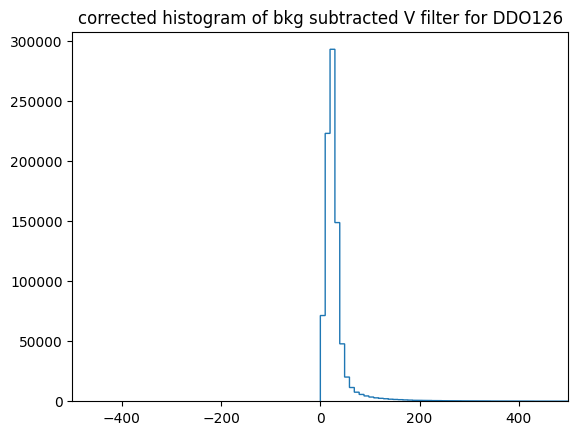

In [6]:
corrected = ltf.background_subtraction(aligned,3,boxes,(3,3))
for i in range(0,3):
    ltf.log_scale_plot(corrected[i],"%s %s bkg corrected"%(galaxy_name,filters[i]),"logscale brightness")
    output_filename = '%s_%s_background_subtracted.fits'%(galaxy_name,filters[i])
    # Create a PrimaryHDU (header/data unit) from your array
    primary_hdu = fits.PrimaryHDU(corrected[i])
    # Create an HDUList and append the PrimaryHDU
    hdul = fits.HDUList([primary_hdu])
    # Write the HDUList to the FITS file
    #hdul.writeto(output_filename, overwrite=True)
    counts, bins = np.histogram(corrected[i], 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()

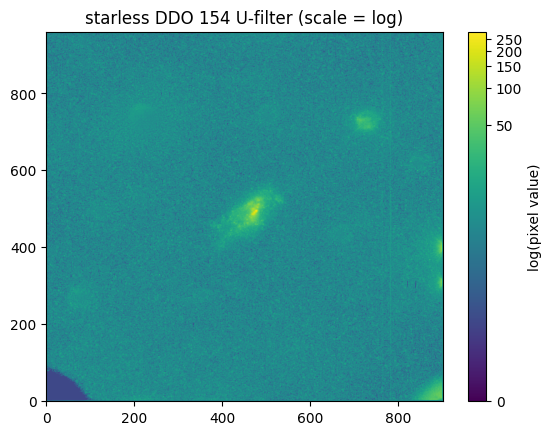

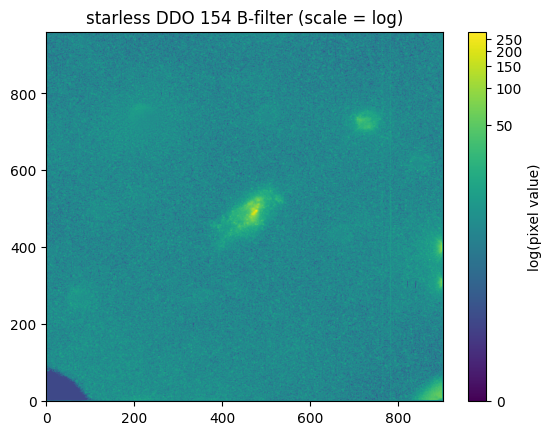

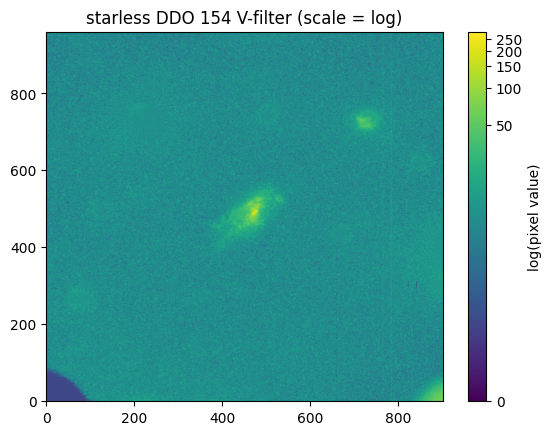

In [7]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d126\starless\starless_DDO126_U_background_subtracted.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d126\starless\starless_DDO126_B_background_subtracted.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code\d126\starless\starless_DDO126_V_background_subtracted.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]

norm = ImageNormalize(vmin=0., stretch=LogStretch())
for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

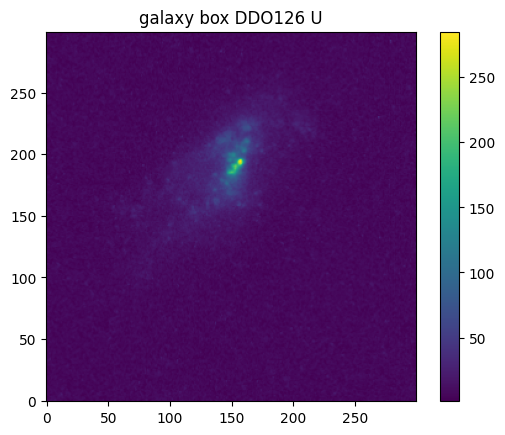

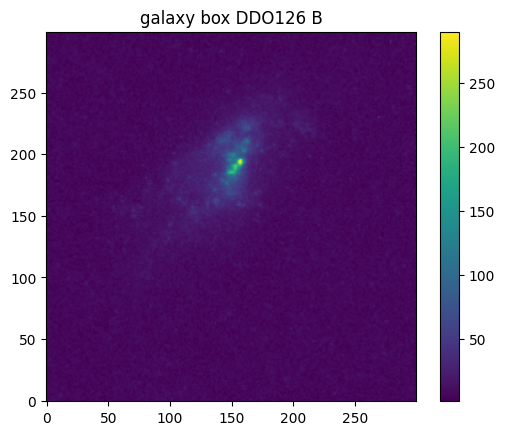

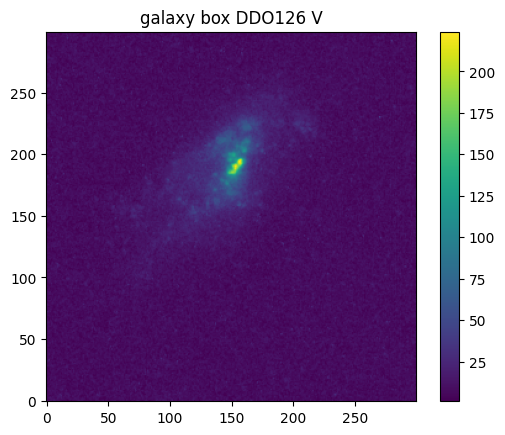

In [9]:
import little_things_functions as ltf
#galaxy_boxes = ltf.get_boxes(starless,[450,470],300)

box_size_x = 150
box_size_y = 150
box_center = [450,470]

galaxy_boxes = []
for i in range(0 , len(starless)):
        box = starless[i][450 - box_size_y : 450 + box_size_y, 470 - box_size_x : 470 + box_size_x]
        galaxy_boxes.append(box)
        
for i in range(0,3):
    plt.imshow(galaxy_boxes[i], origin = "lower")
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
    

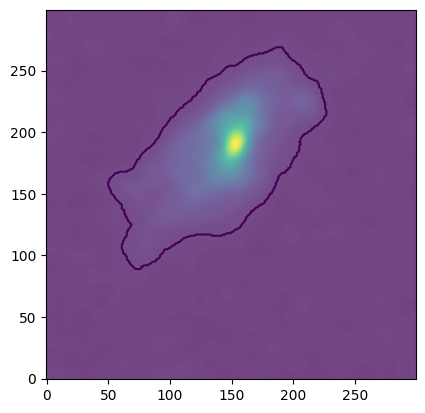

In [19]:
v_value_box = galaxy_boxes[2]
contour_points = ltf.contour_lines_coordinates(v_value_box, 5, [9])
x_points , y_points = contour_points

(159.7432202081339, 148.61234598400395)
[139.17159693 181.18964868  51.11101066 106.59799118  -3.93823252]


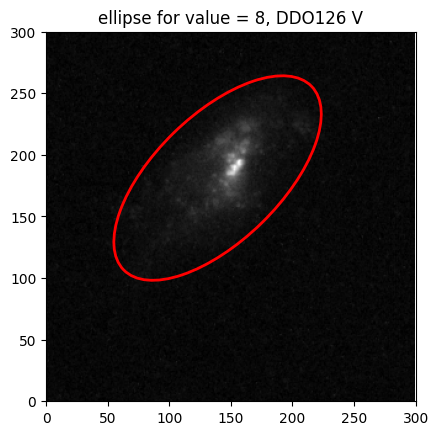

In [20]:
image_center_of_mass = ndimage.center_of_mass(v_value_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_value_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for value = 8, DDO126 V")
# Show the plot
plt.show()

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_18292\2405662592.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry


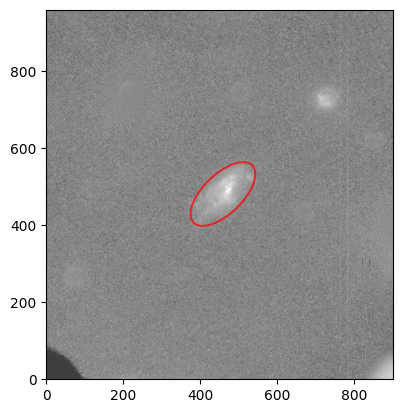

In [21]:
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture
from photutils import aperture_photometry
elliptical_center_box = (xc,yc)
new_xc = xc + (box_center[1]-box_size_x)
new_yc = yc + (box_center[0]-box_size_y)
elliptical_center = (new_xc,new_yc)
ellipse_aper = EllipticalAperture(elliptical_center, a, b, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(starless[2], cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper.plot(color='red', lw=1.5, alpha=0.7) 
plt.show()
phot_table = aperture_photometry(starless[2], ellipse_aper)
aperture_sum_A = phot_table['aperture_sum'][0] 


C:\Users\AYSAN\AppData\Local\Temp\ipykernel_18292\4117985913.py:3: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry
C:\Users\AYSAN\AppData\Local\Temp\ipykernel_18292\4117985913.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry


Aperture sums: [1.4765485471872028e-10, 337.5349131659217, 1370.7374887544304, 3177.3940488064577, 5773.384471374422, 9424.82393339662, 14121.385722493089, 19953.241659537605, 27211.923853463566, 35644.16789001246, 44814.04655562175, 54681.44402475153, 64267.11885988162, 73247.79559607405, 82180.86869822555, 91442.23250256653, 100833.88584543939, 110349.14319485599, 120104.8027683038, 129748.50452505916, 139158.8136107144, 148406.76673565153, 157477.46125039802, 166637.27532649523, 175951.78623721265, 185211.28058419784, 194489.45057900413, 203475.295651489, 212363.64408956032, 221249.56887313043, 229974.1920221186, 238378.12356657235, 246597.89455018286, 254699.01332879107, 262585.6430503727, 270415.06901692075, 278369.3730797042, 286323.8455300628, 294375.3539079859, 302633.5429797553, 310835.4199236443, 318794.7044701102, 326570.3612099153, 334263.1961696835, 341727.2597171974, 349012.5751035488, 356357.80701442517, 363635.2516670963, 370775.1589909776, 378051.4651353583, 385181.322

Text(0.5, 1.0, ' curve of growth for DDO126')

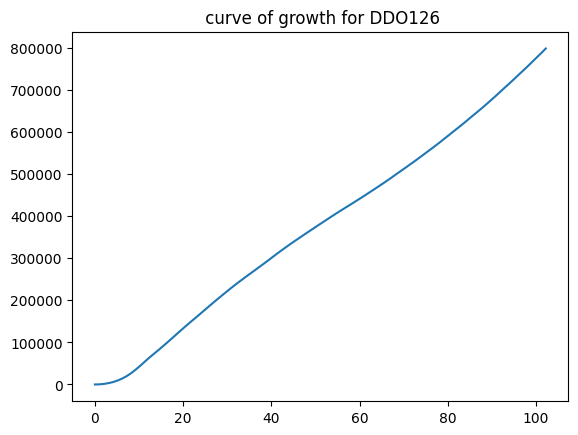

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import EllipticalAperture, aperture_photometry

# Assuming you have defined 'a', 'b', 'theta', 'elliptical_center', and 'v_value_box'
ab_ratio = a / b
ba_ratio = b / a
a_list = np.linspace(0, 2 * a, 100)
b_list = ba_ratio * a_list

sum_values = []

for i in range(len(a_list)):
    # Ensure positive scalar values for major and minor axes
    a_i = max(a_list[i], 1e-6)  # Avoid zero or negative values
    b_i = max(b_list[i], 1e-6)
    ellipse_aper = EllipticalAperture(elliptical_center, a_i, b_i, theta)
    '''
    plt.imshow(starless[2], cmap='gray')  # Replace 'image_data' with your data
    ellipse_aper.plot(color='red', lw=1.5, alpha=0.7)  # Overlay the aperture
    plt.show()
    '''
    # Compute the aperture sum
    phot_table = aperture_photometry(starless[2], ellipse_aper)
    aperture_sum_A = phot_table['aperture_sum'][0]
    sum_values.append(aperture_sum_A)

print("Aperture sums:", sum_values)

plt.plot(a_list , sum_values)
plt.title(" curve of growth for DDO126")

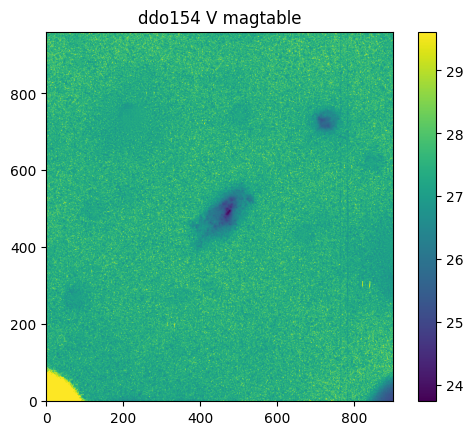

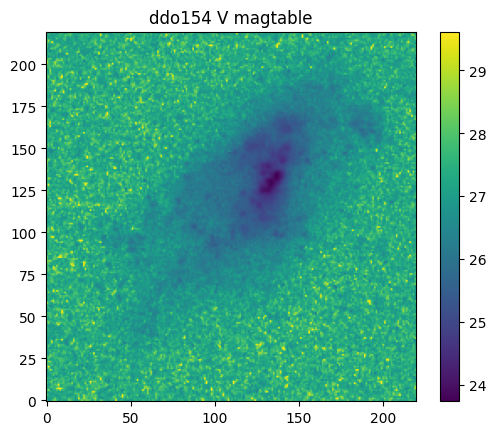

In [13]:
airmass_values=[1.08, 1.00, 1.04]
pixel_scale = 1.134
exposures = [1800, 1800, 1200]
mU_values = [5.203, 0.5026113, -0.0911, 0.]
mB_values = [33.668, 0.2268837, -0.0274, 0.]
mV_values = [3.246, 0.1149137, -0.0167, 0.]
m_values = [mU_values,mB_values,mV_values]

plt.imshow(ltf.mag_table_correction(starless,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

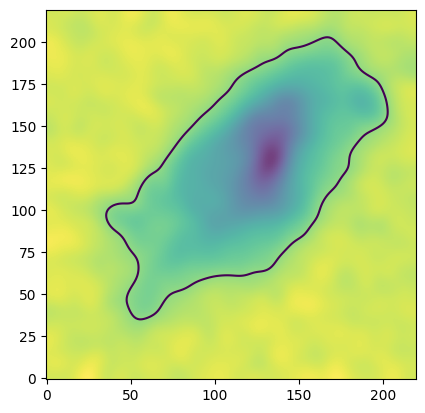

In [16]:
v_box = ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2]
contour_points = ltf.contour_lines_coordinates(v_box, 5, [27])
x_points , y_points = contour_points

In [17]:
image_center_of_mass = ndimage.center_of_mass(v_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]

(109.29737409260048, 109.29992149343354)


[119.7651051  121.68240373 100.37226664  46.52864284 -24.36037899]


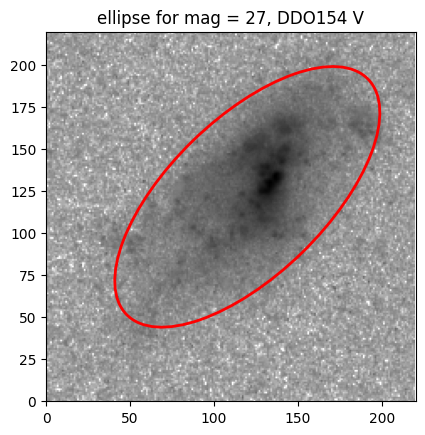

In [19]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_box.shape[1])
ax.set_ylim(0,v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 27, DDO154 V")
# Show the plot
plt.show()